# Droid PaliGemma SAE Training

### Import libraries and define SAE class

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
# this is to only use GPUs 0 and 1
import torch
import tensorflow as tf
import tensorflow_datasets as tfds
from concurrent.futures import ThreadPoolExecutor
from torchvision.utils import make_grid
import requests
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from datasets import load_dataset
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import gc
import wandb
from datetime import datetime
import torch.nn as nn
from torch.cuda.amp import autocast
import multiprocessing as mp
from datasets import Dataset
import numpy as np
from PIL import Image
from IPython import display
import csv
import sys

class SparseAutoencoder(nn.Module):
    def __init__(self, d_in, d_hidden):
        super().__init__()
        self.encoder = nn.Linear(d_in, d_hidden)
        self.activation = nn.ReLU()
        self.decoder = nn.Linear(d_hidden, d_in)

    def forward(self, x):
        z = self.activation(self.encoder(x))
        x_recon = self.decoder(z)
        return x_recon, z

dtype = torch.float16

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

2025-05-05 01:55:54.411792: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 01:55:54.432422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746410154.455788 1195932 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746410154.463393 1195932 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746410154.481826 1195932 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using device: cuda:0


### Load Droid Dataset

There are three options of datasets to collect activations then run SAE on. 

1) All episodes, 20 frames each, equally spaced out: "100_episodes_20_frames_each.pt"
2) 10 episodes, all frames "10_episodes_all_frames.pt"
3) A collage of 6 equally spaced frames in one image--100 images total. "droid_collages_896.pt"

Choose the path that you want. 

In [2]:
DATASET_DIR = "droid_datasets"  # root directory for datasets

available_datasets = {1: "100_episodes_4_frames_each.pt", 2: "10_episodes_all_frames.pt", 3: "droid_collages_896.pt"}

# look at above cell for options
chosen_dataset = 1

dataset_path = os.path.join(DATASET_DIR, available_datasets[chosen_dataset])
print(f"Using dataset: {dataset_path}")
CAPTION_PROMPT = "describe the task the robot is taking:"

class DroidDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        data = torch.load(path)
        self.images = data["images"]
        # self.prompts = data["prompts"]
        # Describe image prompt 
        self.prompts = [CAPTION_PROMPT for _ in self.images]

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        return {
            "image": self.images[idx],
            "prompt": self.prompts[idx]
        }
dataset = DroidDataset(path=dataset_path)
print(f"Loaded dataset: {dataset_path}")

Using dataset: droid_datasets/100_episodes_4_frames_each.pt
Loaded dataset: droid_datasets/100_episodes_4_frames_each.pt


/tmp/ipykernel_1195932/2826579454.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path)


### Load VLM model

There are three options VLAs to choose from:

1) Base Paligemma Model: "base"
2) Finetuned with single images to generate the task instruction: "finetuned_single"
3) Finetuned with collated images to generate the task instruction: "finetuned_collage"

In [3]:
# MODEL_ID = "google/paligemma2-3b-pt-896"
MODEL_ID = "google/paligemma-3b-mix-224"
FINETUNE_PATH_SINGLE = "/home/henrytsai/dhruv/roboterp/finetuned_paligemma_single.pt"
FINETUNE_PATH_COLLAGE = "/home/henrytsai/dhruv/roboterp/finetuned_paligemma.pt"

available_models = {
    "base": {"model_id": MODEL_ID, "finetuned": False},
    "finetuned_single": {"model_id": MODEL_ID, "finetuned": True, "path": FINETUNE_PATH_SINGLE},
    "finetuned_collage": {"model_id": MODEL_ID, "finetuned": True, "path": FINETUNE_PATH_COLLAGE},
}

chosen_model = "base" 

model_info = available_models[chosen_model]
processor = AutoProcessor.from_pretrained(model_info["model_id"])

model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_info["model_id"],
    torch_dtype=dtype
).to(device)

if model_info.get("finetuned", False):
    checkpoint = torch.load(model_info["path"], map_location=device)
    model.load_state_dict(checkpoint)

model.eval()
print(f"Loaded model: {chosen_model}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded model: base


In [4]:
# for name, module in model.named_modules():
#     # if isinstance(module, torch.nn.Linear):
#     #     print(name, "→", module)
#     print(name)

In [5]:
LAYER_DICT = {
    "vision_mlp_fc1": "vision_tower.vision_model.encoder.layers.6.mlp.fc1",
    "vision_attn_out": "vision_tower.vision_model.encoder.layers.6.self_attn.out_proj",
    "fusion_proj": "multi_modal_projector.linear",
    "language_mlp_down": "language_model.model.layers.6.mlp.down_proj",
}

layer_name = LAYER_DICT["fusion_proj"] 

hook_acts = {}

def hook(module, input, output):
    hook_acts["activation"] = output.detach().cpu()

from functools import reduce

def get_module_by_name(model, path):
    return reduce(getattr, path.split("."), model)

In [6]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [7]:
from torch import amp  # for fix 3

# === Config ===
BATCH_SIZE = 2
NUM_WORKERS = 8

def collate_fn(batch):
    images = [example["image"] for example in batch]
    prompts = [example["prompt"] for example in batch]
    return {"images": images, "prompts": prompts}

# === Split dataset across GPUs ===
half = len(dataset) // 2
datasets = [Subset(dataset, range(0, half)), Subset(dataset, range(half, len(dataset)))]
devices = ["cuda:0", "cuda:1"]
activation_lists = [[], []]
token_counts = [[], []]


from tqdm.auto import tqdm  # use auto for better notebook/thread compatibility
from io import StringIO

def run_inference(model, dataloader, device, activations_out, token_counts_out, layer_path):
    model = model.to(device).eval()
    hook_acts = {}

    def hook(module, input, output):
        hook_acts["activation"] = output.detach().cpu()

    handle = get_module_by_name(model, layer_path).register_forward_hook(hook)

    progress_bar = tqdm(
        dataloader,
        desc=f"Inference on {device}",
        leave=True,
        dynamic_ncols=True,
        position=0 if device == "cuda:0" else 1  # prevent conflict
    )

    for batch in progress_bar:
        torch.cuda.empty_cache()
        hook_acts.clear()

        images = batch["images"]
        prompts = [f"<image> {p}" for p in batch["prompts"]]

        model_inputs = processor(
            text=prompts,
            images=images,
            return_tensors="pt",
            padding=True,
            do_rescale=False
        )
        model_inputs = {k: v.to(device, non_blocking=True) for k, v in model_inputs.items()}

        with torch.no_grad(), amp.autocast(device_type="cuda", dtype=torch.bfloat16):
            _ = model(**model_inputs)

        act = hook_acts["activation"]
        if isinstance(act, tuple):
            act = act[0]

        activations_out.append(act.cpu().float())
        token_counts_out.extend([act.shape[1]] * act.size(0))

    handle.remove()

    
from threading import Thread
from torch.utils.data import DataLoader
import copy

dataloaders = [
    DataLoader(datasets[0], batch_size=BATCH_SIZE, collate_fn=collate_fn,
               num_workers=NUM_WORKERS, pin_memory=True),
    DataLoader(datasets[1], batch_size=BATCH_SIZE, collate_fn=collate_fn,
               num_workers=NUM_WORKERS, pin_memory=True)
]

models = [copy.deepcopy(model), copy.deepcopy(model)]
threads = []

for i in range(2):
    t = Thread(target=run_inference, args=(
        models[i], dataloaders[i], devices[i], activation_lists[i], token_counts[i], layer_name))
    t.start()
    threads.append(t)

for t in threads:
    t.join()

all_activations = torch.cat(activation_lists[0] + activation_lists[1], dim=0)
image_to_token_counts = token_counts[0] + token_counts[1]

if all_activations.size(0) == 0:
    raise ValueError("No valid activations collected!")

print("Collected activations:", all_activations.shape)
print("Sum of tokens recorded:", sum(image_to_token_counts))

del models, activation_lists, token_counts, datasets, dataloaders, hook_acts
gc.collect()
torch.cuda.empty_cache()

Inference on cuda:0:   0%|                                                                                    …

Inference on cuda:1:   0%|                                                                                    …

Collected activations: torch.Size([400, 256, 2048])
Sum of tokens recorded: 102400


In [8]:
# # # Convert to half precision before saving (cuts size in half)
# # all_activations_fp16 = all_activations.half()
# torch.save(all_activations.cpu(), "all_activations_safaa.pt")
# torch.save(image_to_token_counts, "image_to_token_counts_safaa.pt")

In [9]:
# # === Load previously saved activations and token counts ===
# all_activations = torch.load("all_activations_safaa.pt")
# image_to_token_counts = torch.load("image_to_token_counts_safaa.pt")

# print("Loaded activations shape:", all_activations.shape)
# print("Loaded token count length:", len(image_to_token_counts))
# all_activations = all_activations.to(device)  # or use your device variable

### Train SAE

wandb: Currently logged in as: htsai (htsai2025) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1 started...


Epoch 1:   8%|█████████████                                                                                                                                                            | 1/13 [00:00<00:08,  1.37it/s]/home/henrytsai/anaconda3/envs/safaa/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)
                                                                                                                                                                                                                      

Epoch 2 started...


Epoch 3 started...


Epoch 4 started...


Epoch 5 started...


Epoch 5: Loss 0.083569
Epoch 6 started...


Epoch 7 started...


Epoch 8 started...


Epoch 9 started...


Epoch 10 started...


Epoch 10: Loss 0.039506
Saved SAE to checkpoints/sae_2025-05-05_01-57-46.pth


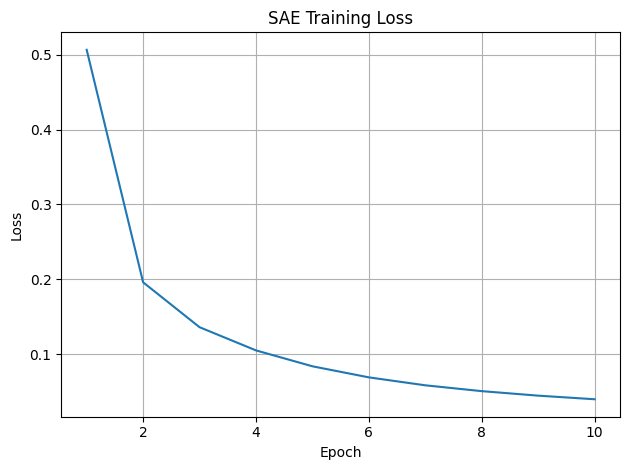

Logged run to sae_run_log.csv


In [10]:
# === Config and Hyperparameters ===
HIDDEN_MULTIPLIER = 8
LEARNING_RATE = 1e-4
SPARSITY_WEIGHT = 1e-2
N_EPOCHS = 10
BATCH_SIZE = 32
NAME_OF_RUN = "SAE_new_notebook_test"
csv_log_path = "sae_run_log.csv"
save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

# === Initialize Weights & Biases ===
wandb.init(project="sparse-autoencoder", name=NAME_OF_RUN, config={
    "hidden_multiplier": HIDDEN_MULTIPLIER,
    "learning_rate": LEARNING_RATE,
    "sparsity_weight": SPARSITY_WEIGHT,
    "n_epochs": N_EPOCHS,
    "batch_size": BATCH_SIZE,
})

# === Model Setup ===
d_in = all_activations.shape[-1]
d_hidden = HIDDEN_MULTIPLIER * d_in

sae = SparseAutoencoder(d_in=d_in, d_hidden=d_hidden).to(device)
sae = torch.nn.DataParallel(sae)  # Split across all visible GPUs

optimizer = torch.optim.AdamW(sae.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.MSELoss()

# === DataLoader ===
train_dataset = torch.utils.data.TensorDataset(all_activations)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

from tqdm import tqdm

# === Training Loop ===
epoch_losses = []
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

for epoch in range(N_EPOCHS):
    sae.train()
    epoch_loss = 0.0
    print(f"Epoch {epoch+1} started...")

    for (batch,) in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        batch = batch.to(next(sae.parameters()).device, non_blocking=True)
        recon, z = sae(batch)

        loss = loss_fn(recon, batch) + SPARSITY_WEIGHT * torch.mean(torch.abs(z))
        epoch_loss += loss.item() * batch.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = epoch_loss / len(train_dataset)
    epoch_losses.append(avg_loss)

    wandb.log({"loss": avg_loss, "epoch": epoch + 1})

    if (epoch + 1) % 5 == 0 or epoch == N_EPOCHS - 1:
        print(f"Epoch {epoch+1}: Loss {avg_loss:.6f}")


# === Save model checkpoint ===
model_path = os.path.join(save_dir, f"sae_{timestamp}.pth")
torch.save({
    "state_dict": sae.state_dict(),
    "d_in": d_in,
    "d_hidden": d_hidden,
}, model_path)
wandb.save(model_path)
print(f"Saved SAE to {model_path}")

# === Plot and log loss curve ===
plt.plot(range(1, N_EPOCHS + 1), epoch_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SAE Training Loss")
plt.grid(True)
plt.tight_layout()
wandb.log({"loss_curve": wandb.Image(plt)})
plt.show()

# === CSV logging ===
run_config = {
    "run_name": NAME_OF_RUN,
    "timestamp": timestamp,
    "hidden_multiplier": HIDDEN_MULTIPLIER,
    "learning_rate": LEARNING_RATE,
    "sparsity_weight": SPARSITY_WEIGHT,
    "n_epochs": N_EPOCHS,
    "batch_size": BATCH_SIZE,
    "d_in": d_in,
    "d_hidden": d_hidden,
    "final_loss": avg_loss,
    "model_path": model_path,
}

write_header = not os.path.exists(csv_log_path)
with open(csv_log_path, mode="a", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=run_config.keys())
    if write_header:
        writer.writeheader()
    writer.writerow(run_config)

sae = sae.module

print(f"Logged run to {csv_log_path}")

### Load previously trained model

### Visualize features

In [17]:
from torchvision.transforms.functional import to_pil_image
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import numpy as np

# ==== CONFIG ====
top_k = 5
n_features_to_plot = 15
batch_size = 4096
num_workers = 8

# ==== STREAM ENCODE ====
sparse_feature_list = []
running_sum = torch.zeros(sae.decoder.in_features, device=device)
count = 0

# with torch.no_grad():
#     for i in range(0, all_activations.size(0), batch_size):
#         batch = all_activations[i:i + batch_size].to(device=device)
#         sparse = sae.activation(sae.encoder(batch))
#         running_sum += sparse.sum(dim=0)
#         count += sparse.size(0)
#         sparse_feature_list.append(sparse.cpu())

sparse_feature_list = []
running_sum = torch.zeros(sae.encoder.out_features, device=device)
count = 0

with torch.no_grad():
    for i in range(0, all_activations.size(0), batch_size):
        batch = all_activations[i:i + batch_size].to(device=device)
        sparse = sae.activation(sae.encoder(batch))  # [B, d_hidden]
        running_sum += sparse.sum(dim=0)             # [d_hidden]
        count += sparse.size(0)
        sparse_feature_list.append(sparse.cpu())

sparse_features = torch.cat(sparse_feature_list, dim=0)

# ==== TOKEN TO IMAGE INDEX MAPPING ====
image_indices_per_token = []
for img_idx, n_tokens in enumerate(image_to_token_counts):
    image_indices_per_token.extend([img_idx] * n_tokens)
image_indices_per_token = np.array(image_indices_per_token)

# ==== TOP FEATURES ====
mean_features = running_sum / count
top_features = torch.topk(mean_features, k=n_features_to_plot).indices.tolist()
print(f"Top {n_features_to_plot} active features:", top_features)

# ==== IMAGE & TEXT LOADER ====
def load_img_and_text(idx):
    img_idx = int(image_indices_per_token[idx])
    entry = dataset[img_idx]
    # Convert image tensor to PIL and then to numpy for plotting
    image_tensor = entry["image"]
    image_pil = to_pil_image(image_tensor)
    prompt = entry["prompt"]
    return np.array(image_pil), prompt

# ==== DISPLAY LOOP ====
for feature_idx in top_features:
    activations = sparse_features[:, feature_idx]
    topk_indices = torch.topk(activations, k=top_k).indices.cpu().tolist()

    # Load image-prompt pairs
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        img_and_text = list(executor.map(load_img_and_text, topk_indices))

    images, prompts = zip(*img_and_text)

    # Plot results
    fig, axes = plt.subplots(1, top_k, figsize=(3 * top_k, 4))
    fig.suptitle(f"Feature {feature_idx} (Top {top_k} Activations)", fontsize=14)

    for ax, img, text in zip(axes, images, prompts):
        ax.imshow(img)
        ax.set_title(text, fontsize=8, wrap=True)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

RuntimeError: output with shape [16384] doesn't match the broadcast shape [256, 16384]

### Sparsity analysis

In [ ]:
# Assume `sae` is already loaded and on the correct device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sae = sae.to(device)
sae.eval()

# Compute feature usage (mean |z|) without storing all z
d_hidden = sae.module.encoder.out_features if isinstance(sae, torch.nn.DataParallel) else sae.encoder.out_features
running_sum = torch.zeros(d_hidden, device=device)
count = 0

with torch.no_grad():
    for (batch,) in train_loader:
        batch = batch.to(device, non_blocking=True)
        _, z = sae(batch)                      # shape: [B, d_hidden] or [B, T, d_hidden]
        z = z.view(-1, z.shape[-1])            # flatten in case it's [B, T, d_hidden]
        running_sum += torch.sum(torch.abs(z), dim=0)
        count += z.shape[0]

feature_usage = running_sum / count

# Plot
plt.figure(figsize=(8, 4))
plt.hist(feature_usage.cpu().numpy(), bins=100)
plt.title("Feature Usage Distribution")
plt.xlabel("Mean |z|")
plt.ylabel("# Features")
plt.grid(True)
plt.tight_layout()
plt.show()
